# Exercise 8
This exercise focuses on CNN architectures. We'll continue using Pytorch.

We will:

- Implement basic architectures.
- Experiment with architectures, hyperparameters and batch normalization.
- Design and implement a Convolutional network that improves classification accuracy.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

### Loading and normalizing the CIFAR10 dataset

The CIFAR-10 dataset consists of 60000 colour images in 10 classes, 50,000 training images and 10,000 test images of size 32 x 32.

https://www.cs.toronto.edu/~kriz/cifar.html


The pytorch provides a package called torchvision, that automatically download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches.


In [4]:
batch_size = 4

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


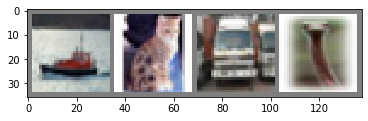

 ship   cat truck  bird


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images[:4,:,:,:])

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



### Define a Convolutional Neural Network

A simple Convolutional Network is a sequence of layers. The most used layers to build ConvNets are Convolutional Layer, Pooling Layer, and Fully-Connected Layer.

Your job is to stack the three main types of layers to form a full ConvNet architecture following the pattern in CIFAR-10:

 [INPUT - CONV - RELU - POOL - FC]
 
* INPUT [32x32x3]: the RGB raw pixel values of the image.
* CONV Convolutional layer with 3 filters and filter size 5 (use padding value 2 to preserve the input dimension).
* RELU applies an elementwise activation function.
* POOL downsampling operation through the spatial dimensions kernel size = 2.
* FC fully-connected layer that computes the class scores, with output size [1x1x10], where each of the 10 numbers corresponds to a class score. Each neuron in this layer will be connected to all the numbers in the previous volume.

Implement the `forward` function, remember that the `backward` pass is computed automatically in Pytorch



In [6]:
Nfilters = 3
Ksize = 5
padding = 2
class ConvNet1(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        # START TODO #############
        # initialize required parameters / layers needed to build the network
        # our batch size of input = 32 *32 * 3
        #input = 32*32*3, ouput = 32*32*3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5,stride=1,padding=2)
        #input = 32*32*3, ouput = 16*16*3
        self.pool = nn.MaxPool2d(kernel_size=2)
        #in_features = 16*16*3, out_features=10
        self.fc = nn.Linear(in_features=768, out_features=10)
        # END TODO #############
        

    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        # START TODO #############
        # batch_size, feature_dim = x.shape
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        N, ht, wt, ch = x.shape
        # Remember to flatten the feature map using:
        # x = x.view(batch_size, dim)
        x = x.view(N, ht*wt*ch)
        x = self.fc(x)
        # END TODO #############
        return x

net = ConvNet1()
print(net)

ConvNet1(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=768, out_features=10, bias=True)
)


Now let's train and see the result of the network. If your implementation is correct, you should get around 47% accuracy.

In [7]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  1000] loss: 0.990
[1,  2000] loss: 0.894
[1,  3000] loss: 0.863
[1,  4000] loss: 0.848
[1,  5000] loss: 0.842
[1,  6000] loss: 0.812
[1,  7000] loss: 0.814
[1,  8000] loss: 0.825
[1,  9000] loss: 0.806
[1, 10000] loss: 0.810
[1, 11000] loss: 0.802
[1, 12000] loss: 0.795
[2,  1000] loss: 0.777
[2,  2000] loss: 0.774
[2,  3000] loss: 0.772
[2,  4000] loss: 0.781
[2,  5000] loss: 0.771
[2,  6000] loss: 0.768
[2,  7000] loss: 0.770
[2,  8000] loss: 0.757
[2,  9000] loss: 0.770
[2, 10000] loss: 0.789
[2, 11000] loss: 0.768
[2, 12000] loss: 0.753
Finished Training
Accuracy of the network on the 10000 test images: 48 %


### Changing the parameters of the network - Number of filters

Use the previous ConvNet and change the number of filters used in the convolutional layer.

(16 or 32 are good options to try!)

Describe what happens when you change the number of filters. Do more or fewer do better?

**Answer**:  
**TODO**  

In [12]:
Nfilters = 16
Ksize = 5
padding = 2
class ConvNet2(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        # START TODO #############
        # initialize required parameters / layers needed to build the network
        # our batch size of input = 32 *32 * 3
        # input = 32*32*3, ouput = 32*32*16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=Nfilters, kernel_size=Ksize, stride=1, padding=2)
        #input = 32*32*16, ouput = 16*16*16
        self.pool = nn.MaxPool2d(kernel_size=2)
        #in_features = 16*16*16, out_features=10
        self.fc = nn.Linear(in_features=4096, out_features=10)
        # END TODO #############

    def forward(self, x):
        """
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            The input to the network will be a minibatch of data
                
        Returns:
            scores: PyTorch Tensor of shape (N, C) giving classification scores for x
        """
        # START TODO #############
        # batch_size, feature_dim = x.shape
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        N, ht, wt, ch = x.shape
        # Remember to flatten the feature map using:
        # x = x.view(batch_size, dim)
        x = x.view(N, ht*wt*ch)
        x = self.fc(x)
        # END TODO #############
        return x

net = ConvNet2()
print(net)

ConvNet2(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


In [13]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  1000] loss: 0.940
[1,  2000] loss: 0.814
[1,  3000] loss: 0.779
[1,  4000] loss: 0.728
[1,  5000] loss: 0.730
[1,  6000] loss: 0.702
[1,  7000] loss: 0.688
[1,  8000] loss: 0.685
[1,  9000] loss: 0.656
[1, 10000] loss: 0.668
[1, 11000] loss: 0.645
[1, 12000] loss: 0.634
[2,  1000] loss: 0.584
[2,  2000] loss: 0.596
[2,  3000] loss: 0.589
[2,  4000] loss: 0.601
[2,  5000] loss: 0.599
[2,  6000] loss: 0.591
[2,  7000] loss: 0.610
[2,  8000] loss: 0.598
[2,  9000] loss: 0.590
[2, 10000] loss: 0.583
[2, 11000] loss: 0.598
[2, 12000] loss: 0.575
Finished Training
Accuracy of the network on the 10000 test images: 59 %


### Changing the parameters of the network - Filter size

The filter size in the last network we use 5x5 filters, now use 3x3 filters and describe what happens, is the network more efficient?

**Answer**:  
**TODO**  



In [16]:
# Nfilters = 16
Nfilters = 32
Ksize = 3
padding = 1
class ConvNet3(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        # START TODO #############
        # Define the layers need to build the network
        # input = 32*32*3, ouput = 32*32*16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=Nfilters, kernel_size=Ksize, stride=1, padding=padding)
        #input = 32*32*16, ouput = 16*16*16
        self.pool = nn.MaxPool2d(kernel_size=2)
        #in_features = 16*16*16, out_features=10
        self.fc = nn.Linear(in_features=8192, out_features=10)
        
        # END TODO #############

    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            The input to the network will be a minibatch of data
                
        Returns:
            scores: PyTorch Tensor of shape (N, C) giving classification scores for x
        """
        # START TODO #############
        # batch_size, feature_dim = x.shape
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        N, ht, wt, ch = x.shape
        # Remember to flatten the feature map using:
        # x = x.view(batch_size, dim)
        x = x.view(N, ht*wt*ch)
        x = self.fc(x)
        
        # Remember to flatten the feature map using x.view
        # must have dimentions: N, 
        
        # END TODO #############
        return x

net = ConvNet3()
print(net)

ConvNet3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)


In [17]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  1000] loss: 0.938
[1,  2000] loss: 0.793
[1,  3000] loss: 0.735
[1,  4000] loss: 0.724
[1,  5000] loss: 0.683
[1,  6000] loss: 0.675
[1,  7000] loss: 0.666
[1,  8000] loss: 0.662
[1,  9000] loss: 0.626
[1, 10000] loss: 0.623
[1, 11000] loss: 0.612
[1, 12000] loss: 0.591
[2,  1000] loss: 0.576
[2,  2000] loss: 0.556
[2,  3000] loss: 0.580
[2,  4000] loss: 0.558
[2,  5000] loss: 0.562
[2,  6000] loss: 0.576
[2,  7000] loss: 0.572
[2,  8000] loss: 0.556
[2,  9000] loss: 0.557
[2, 10000] loss: 0.553
[2, 11000] loss: 0.561
[2, 12000] loss: 0.555
Finished Training
Accuracy of the network on the 10000 test images: 60 %


### Batch normalization

Include batch normalization and describe what happens, is the network more efficient?

**Answer**:  
**TODO**  



In [22]:
Nfilters = 32
Ksize = 3
padding = 1
class ConvNet4(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        # START TODO #############
        # Define the layers need to build the network
        # input = 32*32*3, ouput = 32*32*32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=Nfilters, kernel_size=Ksize, stride=1, padding=padding)
        # batch norm layer for conv1
        self.conv1_bn = nn.BatchNorm2d(num_features=Nfilters)
        #input = 32*32*16, ouput = 16*16*16
        self.pool = nn.MaxPool2d(kernel_size=2)
        #in_features = 16*16*16, out_features=10
        self.fc = nn.Linear(in_features=8192, out_features=10)
        # END TODO #############

    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            The input to the network will be a minibatch of data
                
        Returns:
            scores: PyTorch Tensor of shape (N, C) giving classification scores for x
        """
        # START TODO #############
        x = self.conv1_bn(self.conv1(x))
        x = F.relu(x)
        x = self.pool(x)
        N, ht, wt, ch = x.shape
        # Remember to flatten the feature map using:
        # x = x.view(batch_size, dim)
        x = x.view(N, ht*wt*ch)
        x = self.fc(x)
        
        # Remember to flatten the feature map using x.view
        # must have dimentions: N, 
        
        # END TODO #############
        return x

net = ConvNet4()
print(net)

ConvNet4(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)


In [23]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  1000] loss: 1.230
[1,  2000] loss: 0.817
[1,  3000] loss: 0.770
[1,  4000] loss: 0.753
[1,  5000] loss: 0.720
[1,  6000] loss: 0.705
[1,  7000] loss: 0.690
[1,  8000] loss: 0.662
[1,  9000] loss: 0.667
[1, 10000] loss: 0.644
[1, 11000] loss: 0.641
[1, 12000] loss: 0.625
[2,  1000] loss: 0.583
[2,  2000] loss: 0.590
[2,  3000] loss: 0.573
[2,  4000] loss: 0.590
[2,  5000] loss: 0.567
[2,  6000] loss: 0.606
[2,  7000] loss: 0.580
[2,  8000] loss: 0.562
[2,  9000] loss: 0.581
[2, 10000] loss: 0.582
[2, 11000] loss: 0.572
[2, 12000] loss: 0.571
Finished Training
Accuracy of the network on the 10000 test images: 59 %


Taking into account the previous results, design your own ConvNet to achieve at least 70% of accuracy in max 10 epochs.

You can change the network architecture. The most common ConvNet architecture follows the pattern:

INPUT -> [[CONV -> RELU]\*N -> POOL?]\*M -> [FC -> RELU]\*K -> FC
where the * indicates repetition, and the POOL? indicates an optional pooling layer. Moreover, N >= 0 (and usually N <= 3), M >= 0, K >= 0 (and usually K < 3)

But consider that deeper networks will take a lot of time to train.

You can also change the loss function and the optimizer.


**Describe what you did:**  
**TODO**  



In [32]:
Nfilters1 = 32
Nfilters2 = 64
Nfilters3 = 256
Ksize = 3
padding = 1
class ConvNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # START TODO #############
        # Define the layers need to build the network
        #input = 32*32*3, ouput = 32*32*32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=Nfilters1, kernel_size=Ksize, stride=1, padding=padding)
        # batch norm layer for conv1
        self.conv1_bn = nn.BatchNorm2d(num_features=Nfilters1)
        #input = 32*32*32, ouput = 32*32*64
        self.conv2 = nn.Conv2d(in_channels=Nfilters1, out_channels=Nfilters2, kernel_size=Ksize, stride=1, padding=padding)
        # batch norm layer for conv1
        self.conv2_bn = nn.BatchNorm2d(num_features=Nfilters2)
        #input = 32*32*64, ouput = 32*32*256
        self.conv3 = nn.Conv2d(in_channels=Nfilters2, out_channels=Nfilters3, kernel_size=Ksize, stride=1, padding=padding)
        # batch norm layer for conv1
        self.conv3_bn = nn.BatchNorm2d(num_features=Nfilters3)
        #input = 32*32*256, ouput = 16*16*256
        self.pool = nn.MaxPool2d(kernel_size=2)
        #in_features = 16*16*256, out_features=10
        self.fc = nn.Linear(in_features=65536, out_features=10)
        
        # END TODO #############

    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            The input to the network will be a minibatch of data
                
        Returns:
            scores: PyTorch Tensor of shape (N, C) giving classification scores for x
        """
        # START TODO #############
        x = self.conv1_bn(self.conv1(x))
        x = F.relu(x)
        x = self.conv2_bn(self.conv2(x))
        x = F.relu(x)
        x = self.conv3_bn(self.conv3(x))
        x = F.relu(x)
        x = self.pool(x)
        N, ht, wt, ch = x.shape
        # Remember to flatten the feature map using:
        x = x.view(N, ht*wt*ch)
        # x = self.fc(x)
        # x = F.relu(x)
        # x = self.fc(x)
        # x = F.relu(x)
        x = self.fc(x)
        # END TODO #############
        return x


net = ConvNet5()
print(net)


ConvNet5(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  1000] loss: 2.687
[1,  2000] loss: 0.923
[1,  3000] loss: 0.845
[1,  4000] loss: 0.816
[1,  5000] loss: 0.786
[1,  6000] loss: 0.741
